In [17]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [19]:
wine = pd.read_csv('data/wine_train.csv')

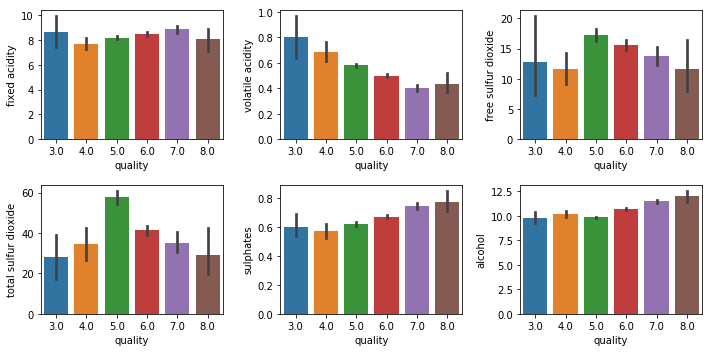

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sns.barplot(x = 'quality', y = 'fixed acidity', data = wine, ax=axes[0,0])
sns.barplot(x = 'quality', y = 'volatile acidity', data = wine, ax=axes[0,1])
sns.barplot(x = 'quality', y = 'free sulfur dioxide', data = wine, ax=axes[0,2])
sns.barplot(x = 'quality', y = 'total sulfur dioxide', data = wine, ax=axes[1,0])
sns.barplot(x = 'quality', y = 'sulphates', data = wine, ax=axes[1,1])
sns.barplot(x = 'quality', y = 'alcohol', data = wine, ax=axes[1,2])
fig.tight_layout()

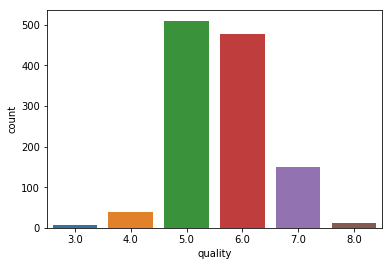

In [21]:
sns.countplot(wine['quality'])

In [23]:
wine['quality'] = pd.cut(wine['quality'], bins = (2, 6.5, 9), labels = [0, 1])

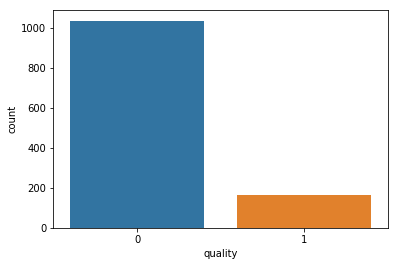

In [24]:
sns.countplot(wine['quality'])

In [6]:
wine['mso2'] = wine['free sulfur dioxide'] / (1 + 10**(wine['pH'] - 1.81))

In [7]:
X = wine.drop(['quality'], axis = 1)
y = wine['quality'].tolist()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [9]:
f1_scorer = make_scorer(f1_score)

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('getfeatures',PolynomialFeatures()),
                 ('classifier', KNeighborsClassifier())])

In [11]:
param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()],
     'getfeatures': [PolynomialFeatures()],
     'getfeatures__degree': [1,2],
     'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [4, 5, 7, 10,12,15,20],
     'classifier__p': [1, 2, 3, 4, 6, 8],
     'classifier__weights': ['uniform','distance'],
       },
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()],
     'getfeatures': [PolynomialFeatures()],
     'getfeatures__degree': [1,2],
     'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': [100],
     'classifier__max_depth': [5,10,25,None],
     'classifier__random_state': [0] 
       }, 
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()],
     'getfeatures': [PolynomialFeatures()],
     'getfeatures__degree': [1,2],
     'classifier': [GradientBoostingClassifier()],
     'classifier__n_estimators': [100],
     'classifier__random_state': [0] 
       }
   
    
    #,
#     {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()],
#      'getfeatures': [PolynomialFeatures()],
#      'getfeatures__degree': [1,2],
#      'classifier': [LogisticRegression()],
#      'classifier__penalty': [ 'l1', 'l2'], 
#      'classifier__C': [ 0.01, 0.1, 0.5, 0.7, 0.9, 1, 10, 100]    
     
#        }
]


CV_find = GridSearchCV(pipe, param_grid, return_train_score=True, cv=kfold , iid=True, n_jobs=-1,scoring=f1_scorer)
CV_find.fit(X_train, y_train)
res=pd.DataFrame(CV_find.cv_results_)
res[res['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,param_getfeatures,param_getfeatures__degree,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
516,0.191651,0.003036,0.014792,0.000419,"(DecisionTreeClassifier(class_weight=None, cri...",NaN,NaN,NaN,"PolynomialFeatures(degree=1, include_bias=True...",1,...,0.554432,0.131741,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
522,0.233694,0.018787,0.017165,0.000922,"(DecisionTreeClassifier(class_weight=None, cri...",NaN,NaN,NaN,"PolynomialFeatures(degree=1, include_bias=True...",1,...,0.554432,0.131741,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [12]:
CV_find.best_estimator_

Pipeline(memory=None,
     steps=[('preprocessing', MinMaxScaler(copy=True, feature_range=(0, 1))), ('getfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto',...mators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [13]:
model = CV_find.best_estimator_
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [14]:
print('Правильность на обучающем наборе: {:.5f}'.format(model.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.5f}'.format(model.score(X_test, y_test)))
print('f1 на тестовом наборе: {:.5f}'.format(f1_score(y_test, y_pred)))

Правильность на обучающем наборе: 1.00000
Правильность на тестовом наборе: 0.92500
f1 на тестовом наборе: 0.64000


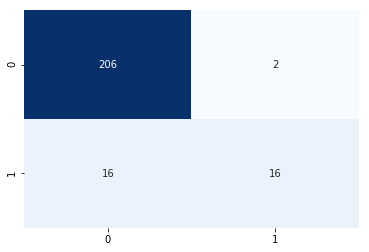

In [15]:
matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(matrix,annot=True, fmt='g', cbar=None,cmap="Blues")
plt.show()

In [16]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       208
           1       0.89      0.50      0.64        32

   micro avg       0.93      0.93      0.93       240
   macro avg       0.91      0.75      0.80       240
weighted avg       0.92      0.93      0.92       240



#### Проверка:

In [ ]:
df_test = pd.read_csv('wine_test.csv')

In [ ]:
df_test['quality'] = pd.cut(df_test['quality'], bins = (2, 6.5, 9), labels = [0, 1])
df_test['mso2'] = df_test['free sulfur dioxide'] / (1 + 10**(df_test['pH'] - 1.81))

In [ ]:
X = df_test.drop(['quality'], axis = 1)
y = df_test['quality'].tolist()

In [ ]:
y_pred=model.predict(X)
matrix=confusion_matrix(y,y_pred)
sns.heatmap(matrix, annot=True, fmt='g', cbar=None, cmap="Blues")
plt.show()
report = classification_report(y, y_pred)
print(report)
print('Правильность на проверочном наборе: {:.10f}'.format(model.score(X, y)))
print('f1 на проверочном наборе: {:.10f}'.format(f1_score(y, y_pred)))